In [765]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder

In [766]:
dataset = pd.read_excel('../data/boxScores.xlsx')

In [767]:
dataset = dataset[dataset['MIN'] != 0]
dataset = dataset.dropna(subset=['W/L'])
dataset.describe()

,GAME DATE,MIN,PTS,FGM,FGA,3PM,3PA,FTM,FTA,OREB,...,PF,+/-,FP,Last3_FP_Avg,Last3_Min,Last5_FP_Avg,Last5_Min,Last7_FP_Avg,Last7_Min,Season_FP_Avg
count,9982,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,...,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000
mean,2024-11-22 14:11:51.200160256,22.482068,10.529253,3.836806,8.263474,1.261170,3.502104,1.594470,2.046584,1.012222,...,1.785514,-0.000701,21.593288,21.480266,22.362369,21.392051,22.268400,21.322921,22.201792,21.572414
min,2024-10-22 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-43.000000,-3.000000,-1.000000,0.666667,-1.000000,1.000000,-1.000000,1.000000,-1.000000
25%,2024-11-06 00:00:00,14.000000,3.000000,1.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,-7.000000,9.700000,11.437500,14.666667,11.661667,14.800000,11.728571,14.723214,12.375000
50%,2024-11-21 12:00:00,24.000000,9.000000,3.000000,7.000000,1.000000,3.000000,1.000000,1.000000,1.000000,...,2.000000,0.000000,19.800000,20.066667,23.333333,20.000000,23.200000,19.900000,23.285714,20.036364
75%,2024-12-08 00:00:00,31.000000,16.000000,6.000000,12.000000,2.000000,5.000000,2.000000,3.000000,2.000000,...,3.000000,7.000000,31.200000,29.891667,30.666667,29.675000,30.600000,29.480357,30.428571,28.755172
max,2024-12-28 00:00:00,48.000000,60.000000,22.000000,39.000000,10.000000,20.000000,17.000000,26.000000,12.000000,...,6.000000,43.000000,98.300000,80.500000,44.666667,75.360000,44.000000,72.200000,44.000000,63.355556
std,NaN,10.847488,8.817063,3.234562,6.034359,1.537369,3.171918,2.246381,2.715058,1.343533,...,1.452097,11.310923,14.981087,13.138480,10.047682,12.732902,9.865021,12.570748,9.792995,11.901225


In [768]:
clusterdf = pd.read_excel('../data/clusteredPlayers.xlsx')

In [769]:
clusterdf = clusterdf.drop('Unnamed: 0', axis=1)
clusterdf.head()

,Player,Cluster
0,Anthony Black,7
1,Bennedict Mathurin,2
2,Clint Capela,4
3,De'Aaron Fox,1
4,Jake LaRavia,6


In [770]:
clusterDict = {}

In [771]:
clusterDict.update(pd.Series(clusterdf['Cluster'].values, index=clusterdf['Player']).to_dict())

In [772]:
dataset['CLUSTER'] = dataset['PLAYER'].map(clusterDict).astype('category')

In [773]:
dataset['CLUSTER'] = dataset['CLUSTER'].replace(clusterDict)
# Remove players without a cluster
dataset = dataset.dropna(subset=['CLUSTER'])
dataset.sort_values(by=['GAME DATE'], ascending = [False], inplace=True)

In [774]:
dataset.describe()


,GAME DATE,MIN,PTS,FGM,FGA,3PM,3PA,FTM,FTA,OREB,...,PF,+/-,FP,Last3_FP_Avg,Last3_Min,Last5_FP_Avg,Last5_Min,Last7_FP_Avg,Last7_Min,Season_FP_Avg
count,7588,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,...,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000
mean,2024-11-22 15:28:45.039536384,26.424354,12.698339,4.619267,9.902214,1.523195,4.190828,1.936610,2.463627,1.158540,...,2.042699,0.188719,25.732275,25.612485,26.309787,25.532406,26.227713,25.471457,26.169713,25.725504
min,2024-10-22 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-43.000000,-2.800000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,8.242105
25%,2024-11-06 00:00:00,20.000000,6.000000,2.000000,6.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,1.000000,-8.000000,15.200000,16.900000,21.000000,17.080000,20.800000,17.162500,20.800000,17.841935
50%,2024-11-22 00:00:00,27.000000,11.000000,4.000000,9.000000,1.000000,4.000000,1.000000,2.000000,1.000000,...,2.000000,0.000000,24.400000,24.133333,26.666667,24.130000,26.600000,24.042857,26.571429,23.884000
75%,2024-12-08 00:00:00,33.000000,18.000000,7.000000,13.000000,2.000000,6.000000,3.000000,4.000000,2.000000,...,3.000000,8.000000,34.500000,32.966667,32.333333,32.540000,32.250000,32.368750,32.142857,32.138462
max,2024-12-28 00:00:00,48.000000,60.000000,22.000000,39.000000,10.000000,20.000000,17.000000,26.000000,12.000000,...,6.000000,43.000000,98.300000,80.500000,44.666667,75.360000,44.000000,72.200000,44.000000,63.355556
std,NaN,8.576619,8.736605,3.209545,5.798668,1.615829,3.220258,2.395641,2.876413,1.416461,...,1.433108,12.287287,14.167288,11.917407,7.548196,11.403778,7.305947,11.190193,7.201513,10.318794


In [775]:
cluster0 = dataset[dataset['CLUSTER'] == 0]
cluster1 = dataset[dataset['CLUSTER'] == 1]
cluster2 = dataset[dataset['CLUSTER'] == 2] 
cluster3 = dataset[dataset['CLUSTER'] == 3]
cluster4 = dataset[dataset['CLUSTER'] == 4]
cluster5 = dataset[dataset['CLUSTER'] == 5]
cluster6 = dataset[dataset['CLUSTER'] == 6]
cluster7 = dataset[dataset['CLUSTER'] == 7]
cluster8 = dataset[dataset['CLUSTER'] == 8]
cluster9 = dataset[dataset['CLUSTER'] == 9]
cluster10 = dataset[dataset['CLUSTER'] == 10]
cluster11 = dataset[dataset['CLUSTER'] == 11]
cluster12 = dataset[dataset['CLUSTER'] == 12]
cluster13 = dataset[dataset['CLUSTER'] == 13]
cluster14 = dataset[dataset['CLUSTER'] == 14]

In [776]:
featureNames = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER']
labelName = ['FP']
dfFeatures = dataset[featureNames]
dfLabels = dataset[labelName]

In [777]:
labels = np.array(dfLabels)
features = np.array(dfFeatures)

In [778]:
dataset = dataset[['PLAYER', 'GAME DATE', 'FP', 'Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER']]
players = dataset['PLAYER']
gameDates = dataset['GAME DATE']

In [779]:
train, test, trainLabels, testLabels, trainPlayers, testPlayers, trainDates, testDates= train_test_split(features, labels, players, gameDates, test_size=0.2, random_state=30)
testPlayers = testPlayers.reset_index(drop=True)
testDates = testDates.reset_index(drop=True)


In [780]:
reg = RandomForestRegressor(
    random_state=4,
)
reg.fit(train, trainLabels)

c:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=4)

In [781]:
train_predictions = reg.predict(train)
predictions = reg.predict(test)

In [782]:
feature_columns = dfFeatures.columns
df = pd.DataFrame(test, columns = feature_columns)
df['PLAYER'] = testPlayers
df['GAME DATE'] = testDates
df['Actual'] = testLabels
df['Predicted'] = predictions
df['Error'] = abs(df['Actual'] - df['Predicted'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

In [783]:
df.describe()

,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,CLUSTER,GAME DATE,Actual,Predicted,Error
count,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1518,1518.000000,1518.000000,1518.000000
mean,25.970136,25.812389,25.718380,25.829244,7.239130,2024-11-22 20:38:53.596837888,26.248221,26.093449,6.426562
min,0.000000,0.000000,0.000000,8.242105,0.000000,2024-10-22 00:00:00,-2.800000,0.172000,0.020000
25%,17.008333,17.320000,17.210714,17.358929,3.000000,2024-11-06 00:00:00,15.300000,17.129750,2.313750
50%,24.400000,24.155000,24.007143,23.884000,7.000000,2024-11-22 00:00:00,25.100000,24.228000,5.160000
75%,33.225000,33.000000,32.792857,32.458333,11.000000,2024-12-08 00:00:00,34.875000,33.811500,9.386000
max,76.433333,71.860000,70.742857,63.355556,14.000000,2024-12-28 00:00:00,87.800000,75.608000,41.381000
std,12.098157,11.686479,11.562480,10.571921,4.157591,NaN,14.427986,12.305034,5.368429


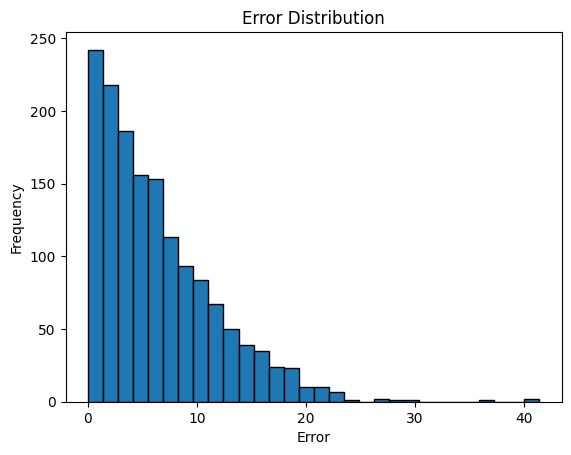

In [784]:
import matplotlib.pyplot as plt

plt.hist(df['Error'], bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

In [785]:
dfgood = df0[(df0['Error']<5)]
dfgood.describe()

,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,Actual,Predicted,Error
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,30.755833,30.254271,30.282932,29.980990,30.603750,30.927837,2.286862
std,10.214909,8.974255,8.644530,6.143187,10.762563,9.678216,1.485399
min,2.400000,2.400000,2.400000,21.113793,2.400000,6.725000,0.058000
25%,25.175000,25.600000,26.298214,25.171429,23.050000,23.845500,1.047500
50%,29.500000,29.130000,28.300000,28.395643,29.900000,30.105500,2.070000
75%,36.050000,35.058750,34.295536,33.427778,36.625000,37.275500,3.659000
max,53.500000,53.500000,53.500000,42.500000,54.700000,52.560000,4.913000


In [786]:
# Identfy unique list of cluster to loop over
clusterdf.head()

,Player,Cluster
0,Anthony Black,7
1,Bennedict Mathurin,2
2,Clint Capela,4
3,De'Aaron Fox,1
4,Jake LaRavia,6


In [787]:
clusterList = clusterdf['Cluster'].tolist()

In [788]:
uniqueClusterList = list(set(clusterList))
uniqueClusterList

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [789]:
ClusterError = 0
for cluster in uniqueClusterList:
    clusterdf = dataset[dataset['CLUSTER'] == cluster]
    dfFeatures = clusterdf[['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg']]
    dfLabels = clusterdf[['FP']]

    labels = np.array(dfLabels).ravel()
    features = np.array(dfFeatures)

    train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=4)

    reg = RandomForestRegressor(random_state=4)
    reg.fit(train, train_labels)

    train_predictions = reg.predict(train)
    predictions = reg.predict(test)

    df0 = pd.DataFrame(test, columns = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg'])
    df0['Actual'] = test_labels
    df0['Predicted'] = predictions
    df0['Error'] = abs(df0['Actual'] - df0['Predicted'])
    ClusterError += df0['Error'].mean()

    print(f"Cluster {cluster} average error is roughly {df0['Error'].mean()}")
avgClusterError = ClusterError/len(uniqueClusterList)
print(f"Average error across clusters is: {avgClusterError}")

KeyError: 'CLUSTER'